In [1]:
import os
import keras
from keras.applications.inception_v3 import preprocess_input# import inception_v3 as inc_net
from keras.preprocessing import image
from keras.models import load_model
from skimage.io import imread
#from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.1.6


In [2]:
img_size = 299
path_to_labels = "./sonstiges/mushroom_labels.txt"

def getHighestID(preds):
    id = 0
    max = -1
    for i in range(len(preds)):
        if preds[i]>max:
            max = preds[i]
            id=i
    return id

def getLabels():
    with open(path_to_labels, 'r') as f:
     myLabels = [line.strip() for line in f]
    return myLabels

def getLabelFromID(id):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if i == id:
                return line
    raise Exception('ID is not in file')
    
def decode_prediction(preds):
    label_list = getLabels()    
    decoded_list = list()
    decoded_list.append([])
    for i in range(len(label_list)):
        decoded_list[0].append([label_list[i],preds[0][i]])
    return decoded_list

def getIDFromLabel(label):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if label == line.replace('\n',''):
                return i
    raise Exception('Label is not in file') 
    

    

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [4]:
my_model = load_model('mushrooms_realtrain_24-06-18_TIME13-15_Epochs20_Steps500_ImageSize299_BatchSize32.h5')
print('Model loaded')


Model loaded


In [5]:
images = transform_img_fn([os.path.join('data','Amanita muscaria.jpg')])
preds = my_model.predict(images)

['Amanita muscaria', 0.9914676]
['Amanita rubescens', 0.004640808]
['Amanita regalis', 0.0035605659]
['Rickenella swartzii', 0.00015101356]
['Armillaria mellea', 0.00014051817]


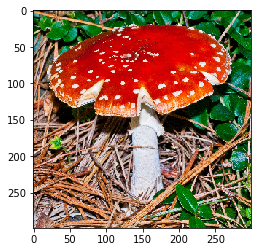

In [6]:
plt.imshow(images[0]/2 +0.5)

preds2 = decode_prediction(preds)[0]
preds2 = sorted(preds2,key=lambda l:l[1], reverse=True)
for x in preds2[:5]:
    print(x)

In [7]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [8]:
explainer = lime_image.LimeImageExplainer()

In [9]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], my_model.predict, hide_color=None, num_samples=1000)

CPU times: user 12.8 s, sys: 1.18 s, total: 14 s
Wall time: 13.5 s


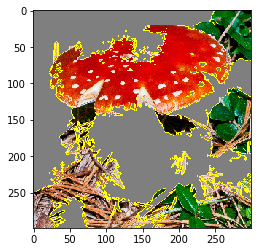

In [10]:
from skimage.segmentation import mark_boundaries
#print(preds.index('Coprinus comatus'))
#print([x for x in preds if 'Coprinus comatus' in x][0])

temp, mask = explanation.get_image_and_mask(getHighestID(preds[0]), positive_only=True, hide_rest=True, num_features=1000)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))